Step 1: Extract HOG feature

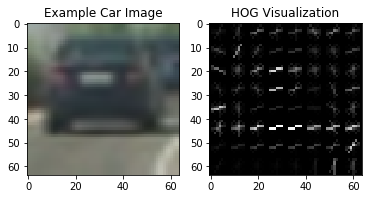

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features.ravel(), hog_image
    else:
        hog_features = return_list
        return hog_features.ravel()

images = ['data/vehicles/GTI_Far/image0001.png','data/vehicles/GTI_Far/image0002.png']
exp_image = mpimg.imread(images[0])
exp_image_gray = cv2.cvtColor(exp_image, cv2.COLOR_RGB2GRAY)

features, hog_image = get_hog_features(exp_image_gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(exp_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')




Step 2 Normalize Feature

In [3]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)
    return features
exp_feature = extract_features(images)

In [4]:
# load the training data
vehicle_path = "W:/Udacity/CarND-Vehicle-Detection-master/data/vehicles/**/*.png"
non_vehicle_path = "W:/Udacity/CarND-Vehicle-Detection-master/data/non-vehicles/**/*.png"
vehicle_list = glob.glob(vehicle_path)
non_vehicle_list = glob.glob(non_vehicle_path)

In [5]:
# check the number of files in dataset
print(len(vehicle_list))
print(len(non_vehicle_list))
# shuffle array
np.random.shuffle(vehicle_list)
np.random.shuffle(non_vehicle_list)

8792
8968


In [6]:
# set up sample size
sample_size = 8500
vehicle_samples = vehicle_list[0:sample_size]
non_vehicle_samples = non_vehicle_list[0:sample_size]

In [7]:
# extract vehicle features and non-vehicle features
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

t=time.time()
car_features = extract_features(vehicle_samples, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_vehicle_samples, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2=time.time()
print(round(t2-t,2), "Seconds to extract HOG features")

151.82 Seconds to extract HOG features


In [8]:
print("shape of the car features vector", len(car_features), "x", len(car_features[0]))
print("shape of the notcar features vector", len(notcar_features), "x", len(notcar_features[0]))

shape of the car features vector 8500 x 1188
shape of the notcar features vector 8500 x 1188


In [9]:
# prepare training data
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [33]:
# Use linear Support Vector Machine
svc = LinearSVC(C = 0.01)
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

6.58 Seconds to train SVC...


In [34]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9788


In [35]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [1. 0. 1. 0. 0. 1. 1. 1. 1. 0.]
For these 10 labels:  [1. 0. 1. 0. 0. 1. 1. 1. 1. 0.]
0.002 Seconds to predict 10 labels with SVC


Sliding Window Implementation

In [36]:
# function to draw boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        

    #9) Return concatenated array of features
    return img_features

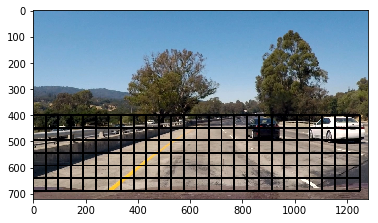

In [37]:
# Test slide window
image_dir = 'test_images/test1.jpg'
image = mpimg.imread(image_dir)
image = image.astype(np.float32)/255
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [38]:
hot_windows = search_windows(image, windows, svc, X_scaler, color_space = colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=False, hog_feat=True)

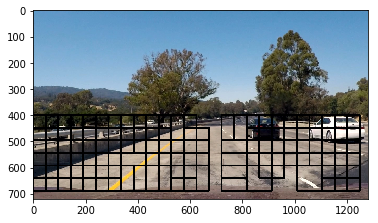

In [39]:
draw_image = np.copy(image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [40]:
# Return original feature shape    
def get_hog_features_original(img, orient, pix_per_cell, cell_per_block, vis=False, 
                     feature_vec=True):
                         
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features.ravel(), hog_image
    else:
        hog_features = return_list
        return hog_features
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, return_ret = False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    # color space transform
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img)
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features_original(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features_original(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features_original(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    rect = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(hog_features).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if return_ret == True:
                    rect.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    if return_ret:
        return rect, draw_img
    return draw_img

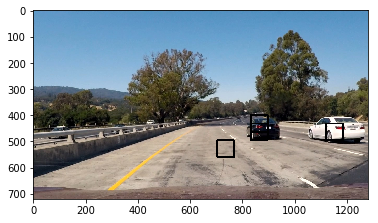

In [41]:
# Test different parameters
boxes = []
ystart = 400
ystop = 656
scale = 1
cspace = colorspace
box, out_img = find_cars(image, ystart, ystop, scale, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, return_ret = True)
boxes.append(box)
plt.imshow(out_img)

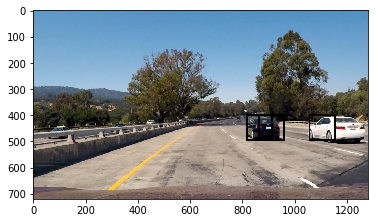

In [42]:
ystart = 400
ystop = 656
scale = 1.5
box, out_img = find_cars(image, ystart, ystop, scale, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, return_ret = True)
boxes.append(box)
plt.imshow(out_img)

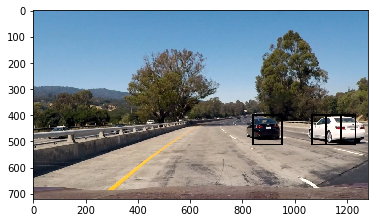

In [43]:
ystart = 400
ystop = 656
scale = 1.75
box, out_img = find_cars(image, ystart, ystop, scale, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, return_ret = True)
boxes.append(box)
plt.imshow(out_img)

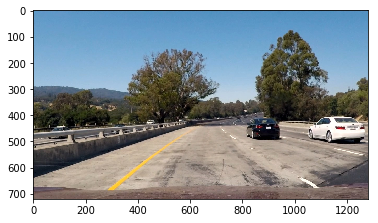

In [44]:
ystart = 400
ystop = 656
scale = 2
box, out_img = find_cars(image, ystart, ystop, scale, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, return_ret = True)
boxes.append(box)
plt.imshow(out_img)

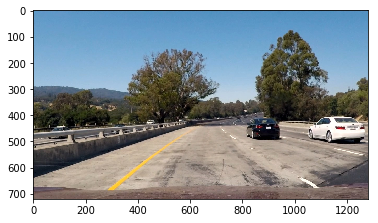

In [45]:
ystart = 400
ystop = 656
scale = 2.5
box, out_img = find_cars(image, ystart, ystop, scale, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, return_ret = True)
boxes.append(box)
plt.imshow(out_img)

Make heat map

In [46]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [47]:
heat_map = np.zeros_like(image[:,:,0])

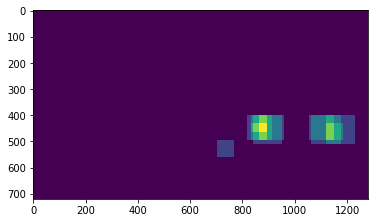

In [48]:
for box in boxes:
    head_map = add_heat(heat_map, box)
plt.imshow(heat_map)

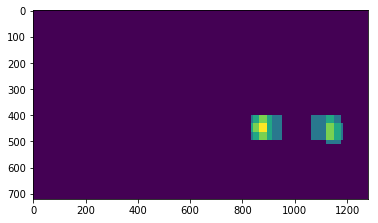

In [49]:
heat_map_thre = apply_threshold(heat_map, 1)
plt.imshow(heat_map_thre)

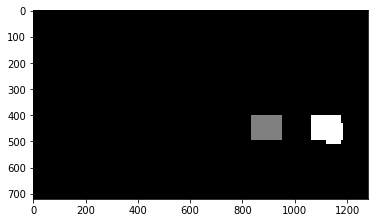

In [50]:
labels = label(heat_map_thre)
plt.imshow(labels[0], cmap = 'gray')

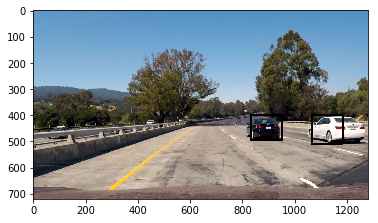

In [51]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img)

In [56]:
# pipeline to go through the process
def vehicle_detection(image, ystart, ystop, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block):
    scales = [1, 1, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]
    ystart_list = [400, 416, 400, 432, 400, 432, 400, 464]
    ystop_list = [464, 480, 496, 528, 528, 560, 596, 660]
    rectangles = []
    for i in range(len(scales)):
        rectangle, _ = find_cars(image, ystart_list[i], ystop_list[i], scales[i], svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, return_ret = True)
        rectangles.append(rectangle)
    heat_map = np.zeros_like(image[:,:,0])
    for box in rectangles:
        heat_map = add_heat(heat_map, box)
    heat_map_thre = apply_threshold(heat_map, 1)
    labels = label(heat_map_thre)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

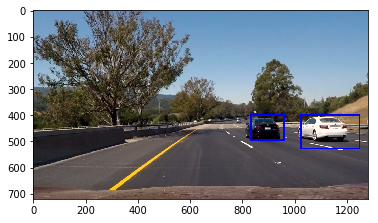

In [57]:
draw_img = vehicle_detection(image, ystart, ystop, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block)
plt.imshow(draw_img)

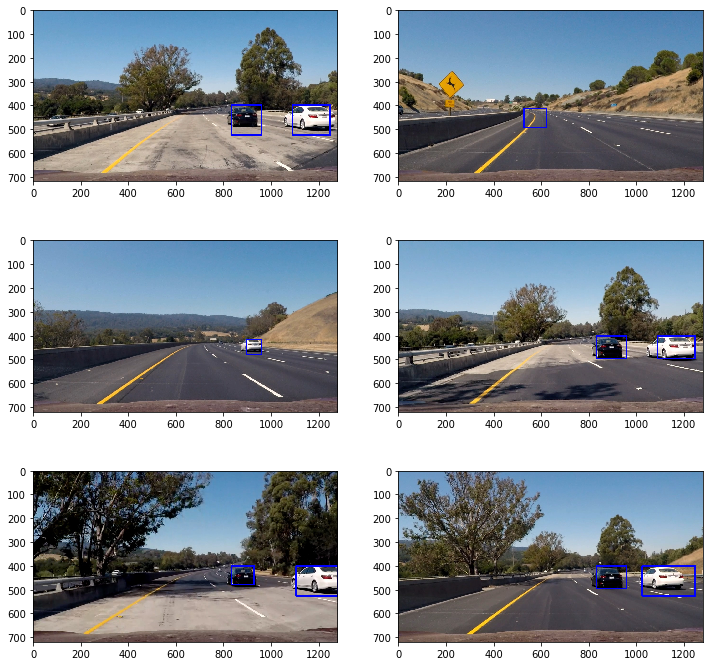

In [58]:
# Test for 6 test images
test_path = "W:/Udacity/CarND-Vehicle-Detection-master/test_images/*.jpg"
test_list = glob.glob(test_path)
fig = plt.figure(figsize = (12, 12))
for i in range(len(test_list)):
    image = mpimg.imread(test_list[i])
    draw_image = vehicle_detection(image, ystart, ystop, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block)
    # Plot the examples
    plot_loc = 321 + i
    plt.subplot(plot_loc)
    plt.imshow(draw_image, cmap='gray')
    

In [67]:
# process the video
from moviepy.editor import ImageSequenceClip
from collections import deque
import cv2
cap = cv2.VideoCapture('project_video.mp4')
image_list = []
def deque_detection(image, ystart, ystop, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, history):
    scales = [1, 1, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]
    ystart_list = [400, 416, 400, 432, 400, 432, 400, 464]
    ystop_list = [464, 480, 496, 528, 528, 560, 596, 660]
    rectangles = []
    for i in range(len(scales)):
        rectangle, _ = find_cars(image, ystart_list[i], ystop_list[i], scales[i], svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, return_ret = True)
        rectangles.append(rectangle)
    heat_map = np.zeros_like(image[:,:,0])
    for box in rectangles:
        heat_map = add_heat(heat_map, box)
    history.append(heat_map)
    cum_heat_map = history[0]
    for i in range(1, len(history)):
        cum_heat_map = cum_heat_map + history[i]
    heat_map_thre = apply_threshold(cum_heat_map, 2)
    labels = label(heat_map_thre)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img
while(cap.isOpened()):
    history = deque(maxlen = 8)
    ret, bgr_frame = cap.read()
    if ret == True:
        '''
        cv2.imshow('image', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        '''
        frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
        result_img = deque_detection(frame, ystart, ystop, svc, cspace, X_scaler, orient, pix_per_cell, cell_per_block, history)
        image_list.append(result_img)
    else:
        break

cap.release()
cv2.destroyAllWindows()

clip = ImageSequenceClip(image_list, fps=30)
clip.write_videofile("output_video.mp4")

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|██████████████████████████████████████| 1254/1254 [00:16<00:00, 74.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

